In [542]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import re
import xgboost as xgb
from sklearn.metrics import precision_score
import os
import gzip
import random
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
#Returns a string of length bytes long
def dataloader(filepath, length):
    f = gzip.GzipFile(fileobj=open(filepath, 'rb'))
    data = f.read(length)
    return data.decode("utf-8")

In [5]:
#Splits the data into num_chunks
def chunk(in_string,num_chunks):
    chunk_size = len(in_string)//num_chunks
    if len(in_string) % num_chunks: chunk_size += 1
    iterator = iter(in_string)
    for _ in range(num_chunks):
        accumulator = list()
        for _ in range(chunk_size):
            try: accumulator.append(next(iterator))
            except StopIteration: break
        yield ''.join(accumulator)

In [132]:
#Returns dataframe of # of files long. Analyze the first length bytes of each file
def trainloader(direclist, filetype, length):
    fileid = np.arange(len(filetype))
    dat = []
    filelabels = []
    c = -1
    for direc in direclist:
        c+=1
        filelabels.append(np.repeat(fileid[c],len(os.listdir(direc))-1))
        for file in os.listdir(direc):
            if file.endswith('.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
    filelabels = np.concatenate(filelabels)
    data = {'Data': dat,
        'Type': filelabels
    }
    df = pd.DataFrame(data, columns = ['Data', 'Type'])
    #print(df.head())
    return(df)

In [163]:
def rowextraction(predicted, truth):
    return(np.where(predicted==truth)[0])

In [209]:
def uncertainty(pred, row_ind, num_classes):
    class_arr = [[] for i in range(num_classes)]
    dist_arr = []
    for ind in row_ind:
        class_ind = np.argmax(pred[ind])
        class_arr[class_ind].append(np.max(pred[ind]))
    for arr in class_arr:
        dist_arr.append([np.mean(arr),np.std(arr)])
    return(dist_arr)

In [7]:
def FeatureImportance(model, features, importance):
    for im in importance:
        feature_important = model.get_score(importance_type = im)
        keys = list(feature_important.keys())
        feature_chars = []
        keylist = []
        for key in keys:
            keylist.append(int(key.replace('f','')))
        for i in keylist:
            feature_chars.append(features[i])
        values = list(feature_important.values())
        fdata = pd.DataFrame(data=values, index=feature_chars, columns=["score"]).sort_values(by = "score", ascending=False)
        fdata.plot(kind='barh', title = im)    
        
    

In [238]:
def confusionmatrix(truth, pred, names):
    cm = confusion_matrix(truth, pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

In [220]:
def classaccuracy(truth, pred, ind, num_classes):
    classes = np.arange(num_classes)
    predcl = np.asarray([np.argmax(pred[i]) for i in ind])
    acc = []
    for cl in classes:
        truth_len = len(np.where(truth == cl)[0])
        pred_len = len(np.where(predcl == cl)[0])
        acc.append(pred_len/truth_len)
    return(acc)

In [587]:
def trainselector(train_data, train_label, n_class, split):
    labelmat = [[] for i in range(n_class)]
    splitnum = []
    datmat = []
    
    total_len = len(train_data)
    for s in split:
        nchoice = int(total_len*s)
        splitnum.append(nchoice)
    
    for c in range(n_class):
        t_labelloc = np.where(train_label == c)[0]
        #print(t_labelloc)
        #print(len(train_data[t_labelloc]))
        labelmat[c].extend(train_data[t_labelloc])
   
    for n in range(len(splitnum)):
        datmat.extend(np.random.choice(labelmat[n],splitnum[n]))
    
    
    return(datmat)
        

In [599]:
def FileClassifier(Dataset, ttsplit, filetype, fit_split, ngram_range, max_features, param, num_round, load):
    
    X = Dataset.iloc[:,0]
    y = Dataset.iloc[:,1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ttsplit, random_state = 42)
    fitset = trainselector(np.array(X_train), np.array(y_train), len(filetype), fit_split)
    
    if load == False:
        print("Generating Character Vectorizer...")
        TfidfVectorizer.partial_fit = partial_fit
        char_vectorizer = TfidfVectorizer(analyzer = 'char',
            ngram_range = ngram_range, max_features = max_features)
        char_vectorizer.fit(fitset)
        print(char_vectorizer.vocabulary_)
        print(char_vectorizer.get_feature_names())
        train_chars = char_vectorizer.transform(X_train)
        test_chars = char_vectorizer.transform(X_test)
        pickle.dump(char_vectorizer, open("tfidfcv.pkl", "wb"))
        print("Character Vectorizer Saved")
        
    if load == True:
        print("Loading Character Vectorizer...")
        char_vectorizer = pickle.load(open("tfidfcv.pkl", 'rb'))
        print("Character Vectorizer Loaded")
        print(char_vectorizer.vocabulary_)
        print(char_vectorizer.get_feature_names())
        train_chars = char_vectorizer.transform(X_train)
        test_chars = char_vectorizer.transform(X_test)

    dtrain = xgb.DMatrix(train_chars, label = y_train)
    dtest = xgb.DMatrix(test_chars, label = y_test)
    
    if load == False:
        print("Training Model...")
        model = xgb.train(param, dtrain, num_round)
        pickle.dump(model, open("xgb_class.pkl", "wb"))
        print("Model Saved")
    if load == True:
        print("Loading Model...")
        model = pickle.load(open("xgb_class.pkl", "rb"))
        print("Model Loaded")
        
    FeatureImportance(model, char_vectorizer.get_feature_names(), ['weight','cover','gain'])
    
    
    preds = model.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    print("Precision: {}".format(precision_score(y_test, best_preds, average='macro')))
    y_test_arr = np.asarray(y_test).reshape(1,-1).squeeze()
    correct_rows = rowextraction(best_preds,y_test_arr)
    class_acc = classaccuracy(y_test_arr, preds, correct_rows, param['num_class'])
    pred_uncertainty = uncertainty(preds, correct_rows, param['num_class'])
    for i in range(param['num_class']):
        print("Class {}".format(filetype[i]) + " mean and sd: {}".format(pred_uncertainty[i])
             + ", Accuracy: {}".format(round(class_acc[i],2)))
    confusionmatrix(y_test_arr, best_preds, filetype)
    
    
    
    return(model)

In [589]:
dirs = ['/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gbff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gff',
       ]
filetype = ['fna', 'gbff', 'gff']
data_iterable = trainloader(dirs, filetype, 3000)

In [471]:
data_iterable.iloc[207,0]

'##gff-version 3\n#!gff-spec-version 1.21\n#!processor NCBI annotwriter\n#!genome-build ASM382199v1\n#!genome-build-accession NCBI_Assembly:GCA_003821995.1\n##sequence-region MG945408.1 1 6522\n##species https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=2202644\nMG945408.1\tGenbank\tregion\t1\t6522\t.\t+\t.\tID=MG945408.1:1..6522;Dbxref=taxon:2202644;Is_circular=true;collection-date=2015;country=China;gbkey=Src;genome=genomic;isolate=4061-1801;isolation-source=pig feces;mol_type=genomic DNA\nMG945408.1\tGenbank\tsequence_feature\t1\t1161\t.\t+\t.\tID=id-MG945408.1:1..1161;Note=similar to VP4;gbkey=misc_feature\nMG945408.1\tGenbank\tsequence_feature\t1043\t1513\t.\t+\t.\tID=id-MG945408.1:1043..1513;Note=similar to hypothetical protein;gbkey=misc_feature\nMG945408.1\tGenbank\tsequence_feature\t1955\t2296\t.\t+\t.\tID=id-MG945408.1:1955..2296;Note=similar to hypothetical protein;gbkey=misc_feature\nMG945408.1\tGenbank\tsequence_feature\t2299\t4443\t.\t+\t.\tID=id-MG945408.1:2299

In [600]:
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(filetype)}  # the number of classes that exist in this datset
num_round = 40 
ngram_range = (4,20)
max_features = 30
fit_split = [0.22, 0.39, 0.39]
Dataset = data_iterable
ttsplit = 0.25
load = True

Loading Character Vectorizer...
Character Vectorizer Loaded
{'aaga': 6, 'agaa': 9, 'gaag': 13, 'gaaa': 12, 'caaa': 11, 'aaaa': 3, 'aaat': 5, 'tgaa': 27, 'aatt': 7, 'attt': 10, 'tttt': 29, 'ttta': 28, 'acaa': 8, 'aaag': 4, 'taaa': 25, 'gene': 14, 'prot': 18, 'rote': 22, 'otei': 16, 'tein': 26, 'prote': 19, 'rotei': 23, 'otein': 17, 'protei': 20, 'rotein': 24, 'protein': 21, 'ion ': 15, '\tgen': 0, '=cds': 2, ';pro': 1}
['\tgen', ';pro', '=cds', 'aaaa', 'aaag', 'aaat', 'aaga', 'aatt', 'acaa', 'agaa', 'attt', 'caaa', 'gaaa', 'gaag', 'gene', 'ion ', 'otei', 'otein', 'prot', 'prote', 'protei', 'protein', 'rote', 'rotei', 'rotein', 'taaa', 'tein', 'tgaa', 'ttta', 'tttt']
Loading Model...
Model Loaded
Precision: 0.9876543209876543
Class fna mean and sd: [0.9659124, 0.035246503], Accuracy: 1.0
Class gbff mean and sd: [0.97711533, 0.0011317126], Accuracy: 1.0
Class gff mean and sd: [0.9752959, 0.0028224555], Accuracy: 0.95


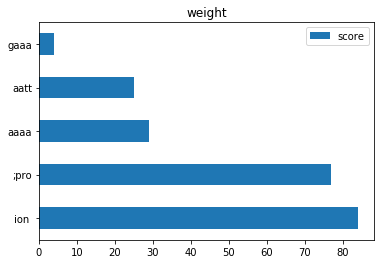

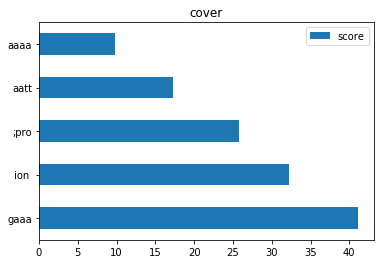

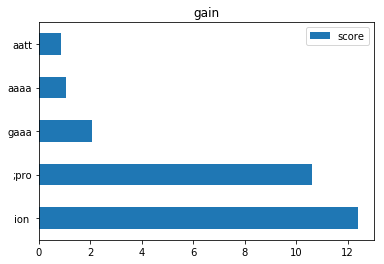

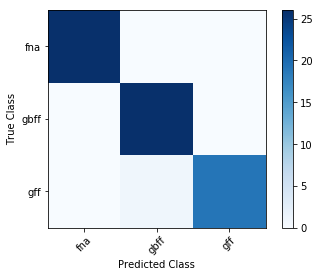

In [601]:
xgbmodel = FileClassifier(Dataset, ttsplit, filetype, fit_split, ngram_range, max_features, param, num_round, load)